<a href="https://colab.research.google.com/github/MarvinLok/Algo-Trading/blob/main/Morningstar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Full guide on yahoofinance API:

https://algotrading101.com/learn/yfinance-guide/

In [130]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
!pip install yfinance
import yfinance as yf
!pip install mplfinance
import mplfinance as mpf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [131]:
SPY_adj = yf.download(tickers="SPY",start="2015-01-01", end="2025-01-01",interval="1d",auto_adjust=True,multi_level_index=False)
SPY_adj.Open

[*********************100%***********************]  1 of 1 completed


,Open
Date,
2015-01-02,172.361472
2015-01-05,170.515711
2015-01-06,168.778629
2015-01-07,168.219029
2015-01-08,170.382049
...,...
2024-12-24,592.520617
2024-12-26,595.940247
2024-12-27,593.991813


SPY_DailyChg represent the length of the candle body

In [132]:
SPY_adj_Open = SPY_adj.Open
SPY_adj_Close = SPY_adj.Close
SPY_DailyChg = SPY_adj_Close - SPY_adj_Open

average length and lower quartile length of candle body will be used in the strategy

In [133]:
SPY_Abs_DailyChg = abs(SPY_DailyChg)
SPY_Abs_DailyChg.describe()

,0
count,2516.000000
mean,1.778542
std,2.002693
min,0.000000
25%,0.434233
50%,1.084253
75%,2.389419
max,17.535830


intiution why morning star is a bullish signal:

a large red candle followed by a small candle represent the end of downward strength. the mid size green candle on the third day confirm the upward strength

the code bvelow return the dates when morning star pattern is confirmed

In [134]:
# first candle is a big red candle body, second candle is a small candle body (either green or red), third candle should be a green candle and its length bigger than half of the first candle
# first condition
morning_condition_1 = [0,0]
for i in range(2, len(SPY_DailyChg)):
    if ( SPY_DailyChg[i-2] < SPY_Abs_DailyChg.mean()*(-1) ) & ( abs(SPY_DailyChg[i-1]) < SPY_Abs_DailyChg.quantile(0.25) ) & ( SPY_DailyChg[i] > SPY_Abs_DailyChg[i-2]*(0.5) ):
        morning_condition_1.append(1)
    else:
        morning_condition_1.append(0)

# second candle's open and close should be strictly below the close of first candle and open of third candle
# second condition
morning_condition_2 = [0,0]
for i in range(2, len(SPY_adj_Open)):
    if ( SPY_adj_Open[i-1] < SPY_adj_Close[i-2] ) & ( SPY_adj_Open[i-1] < SPY_adj_Open[i] ) & ( SPY_adj_Close[i-1] < SPY_adj_Close[i-2] ) & ( SPY_adj_Close[i-1] < SPY_adj_Open[i] ):
        morning_condition_2.append(1)
    else:
        morning_condition_2.append(0)

# Morning Star Signal requires both conditions to be true
morning_star_signal = []
for i in range(len(morning_condition_1)):
    if ( morning_condition_1[i] == 1 ) & ( morning_condition_2[i] == 1 ):
        morning_star_signal.append(1)
    else:
        morning_star_signal.append(0)

# Find Morning Star date (date of third candle)
for i in range(len(morning_star_signal)):
    if morning_star_signal[i] == 1:
        print(SPY_adj.index[i])

2015-07-28 00:00:00
2021-03-22 00:00:00
2021-12-15 00:00:00


Full guide on mplfinance:

https://github.com/matplotlib/mplfinance

In [135]:
custom_colors = mpf.make_marketcolors(
    up='green',     # Color for days where close > open
    down='red',     # Color for days where close < open
    edge='inherit', # Use the same color as the up/down for edges
    wick='inherit', # Use the same color as the up/down for wicks
    volume='in'     # Use the same color as the up/down for volume bars
)

custom_style = mpf.make_mpf_style(
    marketcolors=custom_colors,
    facecolor='lightgrey',      # Light grey background
    gridcolor='white',          # White grid lines
    gridstyle='-',              # Solid grid lines
    y_on_right=False            # Keep Y-axis on the left (default)
)

plot the candle stick charts to ensure we correctly captured the pattern.

Visually they are correct

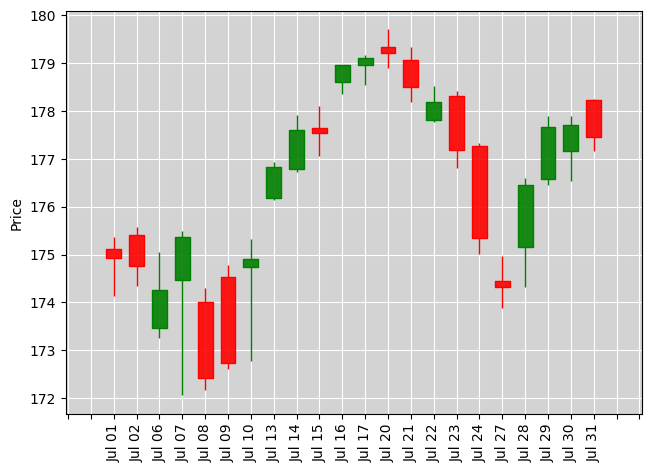

In [136]:
SPY_adj_signal = SPY_adj.loc['2015-07']
fig, axlist = mpf.plot(SPY_adj_signal,type='candle',style=custom_style,returnfig=True, xrotation=90)
axlist[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
mpf.show()

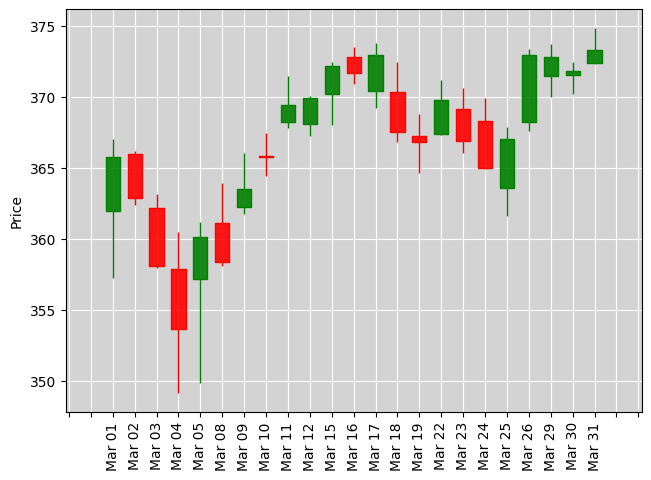

In [137]:
SPY_adj_signal = SPY_adj.loc['2021-03']
fig, axlist = mpf.plot(SPY_adj_signal,type='candle',style=custom_style,returnfig=True, xrotation=90)
axlist[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
mpf.show()

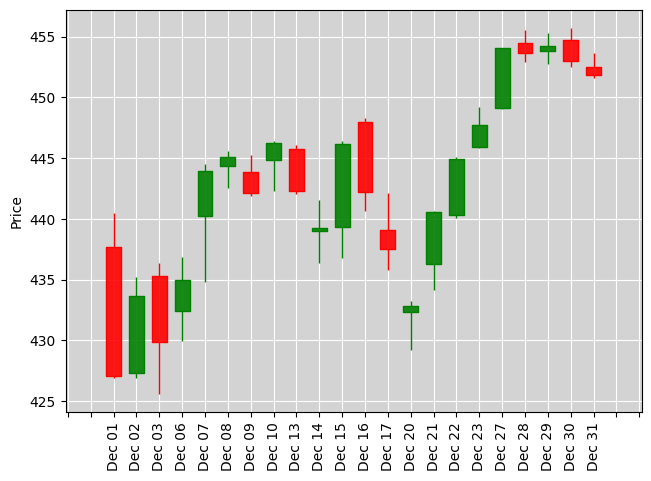

In [138]:
SPY_adj_signal = SPY_adj.loc['2021-12']
fig, axlist = mpf.plot(SPY_adj_signal,type='candle',style=custom_style,returnfig=True, xrotation=90)
axlist[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
mpf.show()

One key flaw of the strategy above is the static mean and lower quartile used across ten years. daily change of 1 dollar ten years ago and daily change of 1 dollar today are clearly different as SPY has grow so much. Let's use rolling two months (i.e. around 44 trading days) candle to derive the mean and lower quartile

the new strategy generate more trading signals

In [139]:
# Calculate rolling mean and lower quartile over 44 days, shifted by 1 day to above look ahead bias
rolling_mean = SPY_Abs_DailyChg.rolling(44).mean().shift(1)
rolling_lower_quartile = SPY_Abs_DailyChg.rolling(44).quantile(0.25).shift(1)

# Initialize condition lists with zeros
morning_condition_1 = [0] * len(SPY_DailyChg)
morning_condition_2 = [0] * len(SPY_DailyChg)

In [140]:
# Condition 1: Check Morning Star pattern using rolling statistics
for i in range(2, len(SPY_DailyChg)):
    if (SPY_DailyChg.iloc[i-2] < rolling_mean.iloc[i]*(-1)) and \
       (abs(SPY_DailyChg.iloc[i-1]) < rolling_lower_quartile.iloc[i]) and \
       (SPY_DailyChg.iloc[i] > SPY_Abs_DailyChg[i-2]*(0.5)):
        morning_condition_1[i] = 1

# Condition 2: Check price relationships
for i in range(2, len(SPY_adj_Open)):
    if ( SPY_adj_Open[i-1] < SPY_adj_Close[i-2] ) & ( SPY_adj_Open[i-1] < SPY_adj_Open[i] ) & ( SPY_adj_Close[i-1] < SPY_adj_Close[i-2] ) & ( SPY_adj_Close[i-1] < SPY_adj_Open[i] ):
        morning_condition_2[i] = 1


# Morning Star Signal requires both conditions to be true
morning_star_signal = []
for i in range(len(morning_condition_1)):
    if ( morning_condition_1[i] == 1 ) & ( morning_condition_2[i] == 1 ):
        morning_star_signal.append(1)
    else:
        morning_star_signal.append(0)

# Find Morning Star date (date of third candle)
for i in range(len(morning_star_signal)):
    if morning_star_signal[i] == 1:
        print(SPY_adj.index[i])

2015-06-10 00:00:00
2015-07-28 00:00:00
2015-08-10 00:00:00
2019-09-04 00:00:00
2021-03-22 00:00:00
2021-12-15 00:00:00
2023-01-20 00:00:00


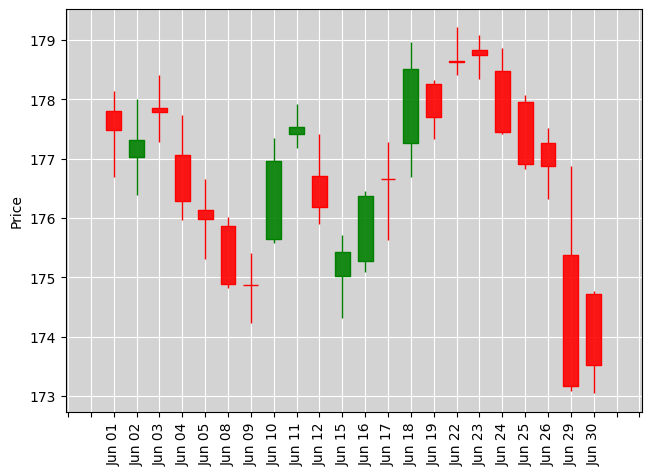

In [141]:
SPY_adj_signal = SPY_adj.loc['2015-06']
fig, axlist = mpf.plot(SPY_adj_signal,type='candle',style=custom_style,returnfig=True, xrotation=90)
axlist[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
mpf.show()

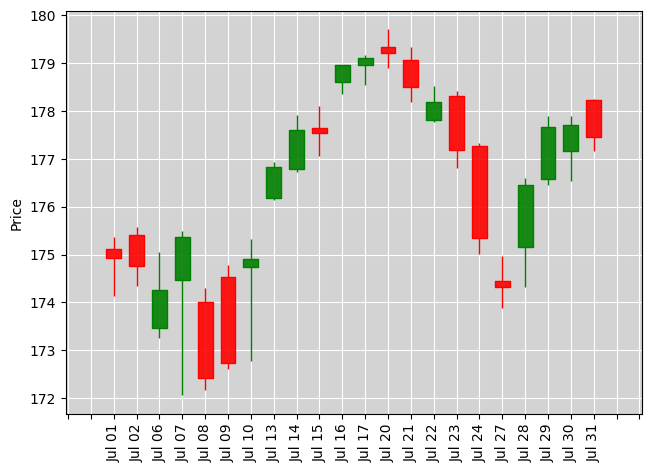

In [142]:
SPY_adj_signal = SPY_adj.loc['2015-07']
fig, axlist = mpf.plot(SPY_adj_signal,type='candle',style=custom_style,returnfig=True, xrotation=90)
axlist[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
mpf.show()

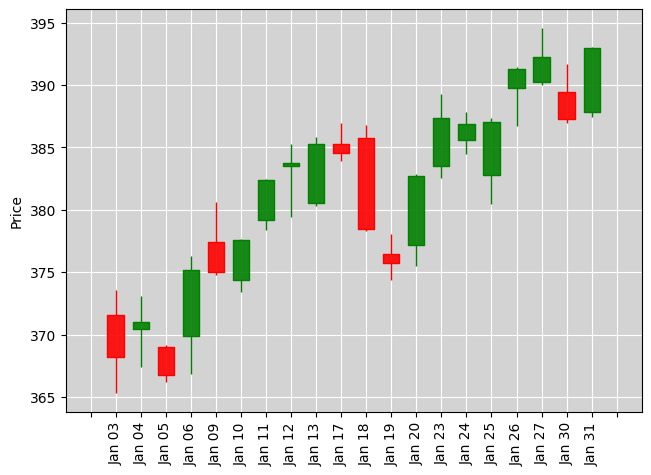

In [143]:
SPY_adj_signal = SPY_adj.loc['2023-01']
fig, axlist = mpf.plot(SPY_adj_signal,type='candle',style=custom_style,returnfig=True, xrotation=90)
axlist[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
mpf.show()